In [89]:
import pandas as pd
import numpy as np

In [90]:
index50 = pd.read_csv('台灣50指數資料.csv', encoding='utf-16', sep='\t')

In [91]:
#計算市值與權重並新增欄位
index50['市值'] = index50['公眾流通係數'] * index50['前日調整收盤價']*index50['股數']
index50['成份股'] = index50['成份股'].str.split(' ').str[0]
index50

,證券代碼,年月日,成份股,指數因子,公眾流通係數,股數,前日調整收盤價,前日市值比重,市值
0,TWN50 台灣50指數,20190102,1101,0.0021,0.8700,5108059911,35.60,1.0261,1.582068e+11
1,TWN50 台灣50指數,20190102,1102,0.0011,0.6900,3361447198,33.95,0.5107,7.874358e+10
2,TWN50 台灣50指數,20190102,1216,0.0023,0.8500,5682015421,69.80,2.1865,3.371140e+11
3,TWN50 台灣50指數,20190102,1301,0.0023,0.7700,6365740781,101.00,3.2110,4.950637e+11
4,TWN50 台灣50指數,20190102,1303,0.0027,0.7200,7930821589,75.50,2.7962,4.311195e+11
...,...,...,...,...,...,...,...,...,...
48896,TWN50 台灣50指數,20221230,5880,0.0044,0.7200,14008935446,25.65,1.0845,2.587170e+11
48897,TWN50 台灣50指數,20221230,6415,0.0001,0.6600,381075821,432.50,0.4560,1.087781e+11
48898,TWN50 台灣50指數,20221230,6505,0.0006,0.1500,9525959652,79.70,0.4774,1.138828e+11
48899,TWN50 台灣50指數,20221230,8046,0.0001,0.3249,646165487,231.00,0.2033,4.849595e+10


In [92]:
stock_list = index50['成份股'].unique()
stock_list

array(['1101', '1102', '1216', '1301', '1303', '1326', '1402', '2002',
       '2105', '2301', '2303', '2308', '2317', '2327', '2330', '2354',
       '2357', '2382', '2395', '2408', '2409', '2412', '2454', '2474',
       '2633', '2801', '2823', '2880', '2881', '2882', '2883', '2884',
       '2885', '2886', '2887', '2890', '2891', '2892', '2912', '3008',
       '3045', '3481', '3711', '4904', '4938', '5871', '5876', '5880',
       '6505', '9904', '2207', '9910', '2888', '6669', '2379', '6415',
       '3034', '8046', '1590', '2603', '2609', '2615', '8454', '3037',
       '6770'], dtype=object)

In [93]:
#將dataframe依照年月日切割，存入dict, ex. data_dict['2019/01/02']可取出當天的資料
data_of_the_date = {}
for i in range(0, len(index50)):
    if index50['年月日'][i] not in data_of_the_date:
        data_of_the_date[index50['年月日'][i]] = index50.iloc[i:i+1]
    else:
        data_of_the_date[index50['年月日'][i]] = pd.concat([data_of_the_date[index50['年月日'][i]], index50.iloc[i:i+1]])

In [94]:
# # 範例
# data_of_the_date[20190102]

In [95]:
#算權重
def get_weight(daily_data):
    stock_and_weight = {}
    total_value = daily_data['市值'].sum()
    for i in range(len(daily_data)):
        stock_and_weight[daily_data['成份股'][i]] = daily_data['市值'][i]/total_value
    return stock_and_weight

# # 使用範例
# get_weight(data_of_the_date[20190102])

In [96]:
import datetime as dt
import calendar

def find_last_weekday(year):
    months = [2, 5, 8, 11]
    last_days = []
    for month in months:
        num_days = calendar.monthrange(year, month)[1]

        # 取得當月最後一天的日期
        last_day = dt.date(year, month, num_days)

        # 若最後一天是週末，往前推算直到非週末
        while last_day.weekday() >= 5:  # 5 和 6 分別代表週六和週日
            last_day -= dt.timedelta(days=1)
        last_days.append(str(last_day).replace('-', ''))

    return last_days

# 使用範例
year = 2023
find_last_weekday(year)


['20230228', '20230531', '20230831', '20231130']

台50指每3.6.9.12月會調整一次成分股，調整依照前一個月(2,5,8,11)最後一個交易日的資料為參考來調整權重。

In [97]:
import datetime

def get_month(date_intstring):
    date = datetime.datetime.strptime(str(date_intstring).split('\n')[0].strip(), '%Y%m%d')
    return date.month

def convert_to_minguo_date(date_str):
    date_obj = datetime.datetime.strptime(str(date_str), '%Y%m%d')
    minguo_year = date_obj.year - 1911
    minguo_date_str = date_obj.strftime(f"{minguo_year}%m%d")
    return minguo_date_str

In [98]:
def convert_format_to_float(s):
    s_without_commas = s.replace(',', '')
    s_as_integer = float(s_without_commas)
    return s_as_integer


In [99]:
import requests
import pandas as pd

def get_stock_data_for_year(year, stock_code):
    stock_data = []
    for year in range(year-1, year+1):
        for month in range(1, 13):
            # 构建URL
            date = f"{year}{month:02d}01"  # 以指定年份和月份构建日期
            url = f"https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date={date}&stockNo={str(stock_code)}"

            # 发送请求
            response = requests.get(url)
            data = response.json()

            # 解析数据
            if 'data' in data:
                stock_data += data['data']
    if stock_data:
        df = pd.DataFrame(stock_data, columns=['Date', 'Volume', 'Turnover', 'Open', 'High', 'Low', 'Close', 'Change', 'Transaction'])
        df['Date'] = df['Date'].str.replace('/', '')
        c = df['Close'] != '--'
        df = df[c]
        df = df.reset_index(drop=True)
        df['Close'] = df['Close'].apply(convert_format_to_float)
        return df

# 示範用法
year = 2022  
stock_code = 2330  

get_stock_data_for_year(year, stock_code)


,Date,Volume,Turnover,Open,High,Low,Close,Change,Transaction
0,1100104,"39,489,959","21,127,581,248",530.00,540.00,528.00,536.0,+6.00,"33,316"
1,1100105,"34,839,391","18,761,831,567",536.00,542.00,535.00,542.0,+6.00,"28,512"
2,1100106,"55,614,434","30,572,783,229",555.00,555.00,541.00,549.0,+7.00,"55,462"
3,1100107,"53,392,763","30,018,630,685",554.00,570.00,553.00,565.0,+16.00,"47,905"
4,1100108,"62,957,148","36,339,702,855",580.00,580.00,571.00,580.0,+15.00,"56,426"
...,...,...,...,...,...,...,...,...,...
485,1111226,"9,152,790","4,171,194,858",454.00,457.00,453.50,456.5,+1.50,"16,718"
486,1111227,"10,486,219","4,820,155,221",458.00,462.50,457.00,457.0,+0.50,"13,482"
487,1111228,"34,823,492","15,643,266,841",451.00,452.00,446.00,451.0,-6.00,"59,400"
488,1111229,"25,596,357","11,400,284,554",444.00,449.50,442.50,446.0,-5.00,"34,637"


In [100]:
def get_stockDailyReturn_by_date(stock, date, stock_price):
    _index = stock_price[stock_price['Date'] == str(convert_to_minguo_date(date))].index
    result_df = stock_price.loc[_index.union(_index-1)]
    try:
        daily_return = (float(result_df['Close'].iloc[1]) - float(result_df['Close'].iloc[0])) / float(result_df['Close'].iloc[0])
    except Exception as e:
        print(f'股票:{stock} 在{date}計算日報酬時出現錯誤：' + str(e))
        daily_return = 0
    return daily_return * 100

# #使用範例
# get_stockDailyReturn_by_date(2330, 20200106)
    

In [104]:
def tracking(start_date, end_date, data_of_the_date, index50):
    year = int(str(start_date)[:4])
    stock_price_dict = {}
    for stock in stock_list:
        stock_price_dict[stock] = get_stock_data_for_year(year, stock)
    #先找出本年度調整參考月的最後一個交易日(去年11月，今年2、5、8月)
    last_years = year - 1
    last_days = []
    last_days = last_days + [find_last_weekday(last_years)[3]]
    last_days = last_days + find_last_weekday(year)[:3]
    print(f"權重調整參考日： {last_days}")

    #用調整參考月的最後一個交易日將新的權重算出來
    weights = []
    for day in last_days:
        #有可能該日沒開盤，若沒開盤則往前推算到有資料為止
        date = day
        try:
            weights.append(get_weight(data_of_the_date[int(day)]))
        except:
            while True:
                date = str(int(date)-1)
                try:
                    weights.append(get_weight(data_of_the_date[int(date)]))
                    break
                except:
                    continue
            
    day_list = list(index50['年月日'])
    day_set = sorted(set(day_list))
    portfolio_daily_return = []
    for day in day_set:
        if int(day) < int(start_date) or int(day) > int(end_date):
            continue
        if day not in data_of_the_date:
            continue
        #判斷該日該採用哪個調整參考月的權重
        if get_month(day) <= 3:
            weight_combination = weights[0]
        elif get_month(day) <= 6:
            weight_combination = weights[1]
        elif get_month(day) <= 9:
            weight_combination = weights[2]
        else:
            weight_combination = weights[3]

        #成分股當日報酬率乘上權重後相加為投組當日報酬率
        daily_return = 0
        for stock in weight_combination:
            daily_return += get_stockDailyReturn_by_date(int(stock), int(day), stock_price_dict[str(stock)]) * weight_combination[stock]
        portfolio_daily_return.append(daily_return)

    return portfolio_daily_return
    
    
    

In [105]:
start_day = 20200101
end_day = 20201231

In [106]:
tracking_return = tracking(start_day, end_day, data_of_the_date, index50)

權重調整參考日： ['20191129', '20200228', '20200529', '20200831']
股票:4938 在20200813計算日報酬時出現錯誤：single positional indexer is out-of-bounds
股票:2474 在20200818計算日報酬時出現錯誤：single positional indexer is out-of-bounds


In [107]:
len(tracking_return)

245

In [108]:
index50_daily_return = pd.read_csv('台灣50指數日報酬.csv', encoding='utf-16', sep='\t')
c1 = index50_daily_return['年月日'] >= start_day
c2 = index50_daily_return['年月日'] <= end_day
index50_daily_return = index50_daily_return[c1 & c2]
index50_daily_return

,證券代碼,年月日,日報酬率 %
242,TWN50 台灣50指數,20200102,1.0139
243,TWN50 台灣50指數,20200103,0.2616
244,TWN50 台灣50指數,20200106,-1.5974
245,TWN50 台灣50指數,20200107,-0.5566
246,TWN50 台灣50指數,20200108,-0.5217
...,...,...,...
482,TWN50 台灣50指數,20201225,0.3288
483,TWN50 台灣50指數,20201228,0.8832
484,TWN50 台灣50指數,20201229,-0.1253
485,TWN50 台灣50指數,20201230,1.8557


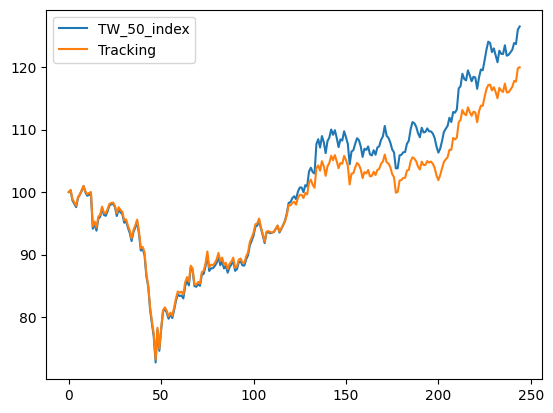

In [109]:
#畫出台50指成長曲線
import matplotlib.pyplot as plt

index50_assets = []
for i in range(len(index50_daily_return)):
    if i == 0:
        index50_assets.append(100)
    else:
        index50_assets.append(index50_assets[i-1] * (1 + list(index50_daily_return['日報酬率 %'])[i]/100))

tracking_assets = []
for i in range(len(tracking_return)):
    if i == 0:
        tracking_assets.append(100)
    else:
        tracking_assets.append(tracking_assets[i-1] * (1 + tracking_return[i]/100))

plt.plot(index50_assets, label='TW_50_index')
plt.plot(tracking_assets, label='Tracking')
plt.legend()

In [110]:
dif = []
for i in range(len(tracking_return)):
    dif.append(tracking_return[i] - list(index50_daily_return['日報酬率 %'])[i])
np.array(dif).std() * np.sqrt(252)

2.9612282020272844